In [2]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

from pclib.nn.models import FCClassifierSS
from pclib.optim.train import train
from pclib.optim.eval import track_vfe, accuracy
from pclib.utils.functional import reTanh
from pclib.utils.customdataset import PreloadedDataset

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [25]:

class TanhTransform(object):
    def __init__(self, a=1., b=0., c=1.0):
        self.a = a
        self.b = b
        self.c = c

    def __call__(self, img):
        return ((img * self.a).tanh() + self.b) * self.c

class InvTanhTransform(object):
    def __call__(self, img):
        num = 1 + img
        div = (1 - img).clamp(min=1e-6)
        m = 0.5 * torch.log(num / div)
        return m

class SigmoidTransform(object):
    def __call__(self, img):
        return img.sigmoid()
    
class ReLUTanhTransform(object):
    def __call__(self, img):
        return F.relu(img.tanh())

train_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
    # transforms.Normalize((0.1307,), (0.3081,)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    # InvTanhTransform(),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform(a=2.0),
    # TanhTransform(a=1.0, b=1.0, c=0.5),
])

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())
# shorten dataset
length = 10
dataset = torch.utils.data.Subset(dataset, range(length))
train_dataset = PreloadedDataset.from_dataset(dataset, train_transform, device)

# VAL_RATIO = 0.2
# val_len = int(len(dataset) * VAL_RATIO)
# train_len = len(dataset) - val_len
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
# train_dataset = PreloadedDataset.from_dataset(train_dataset, train_transform, device)
# val_dataset = PreloadedDataset.from_dataset(val_dataset, val_transform, device)
INPUT_SHAPE = 784
NUM_CLASSES = 10

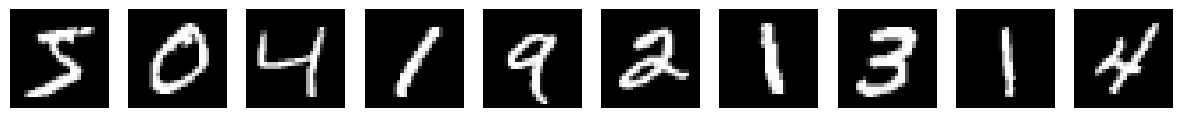

Max value:  tensor(1., device='cuda:0')
Min value:  tensor(0., device='cuda:0')


In [26]:
# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', train_dataset.transformed_images.max())
print('Min value: ', train_dataset.transformed_images.min())

In [27]:
seed = 42
torch.manual_seed(seed)

model = FCClassifierSS(
    in_features=INPUT_SHAPE, 
    num_classes=NUM_CLASSES, 
    hidden_sizes=[200, 200],
    bias=True, 
    symmetric=True, 
    precision_weighted=False,
    actv_fn=reTanh,
    steps=100,
    gamma=0.34,
    ).to(device)
step = 0
stats = None

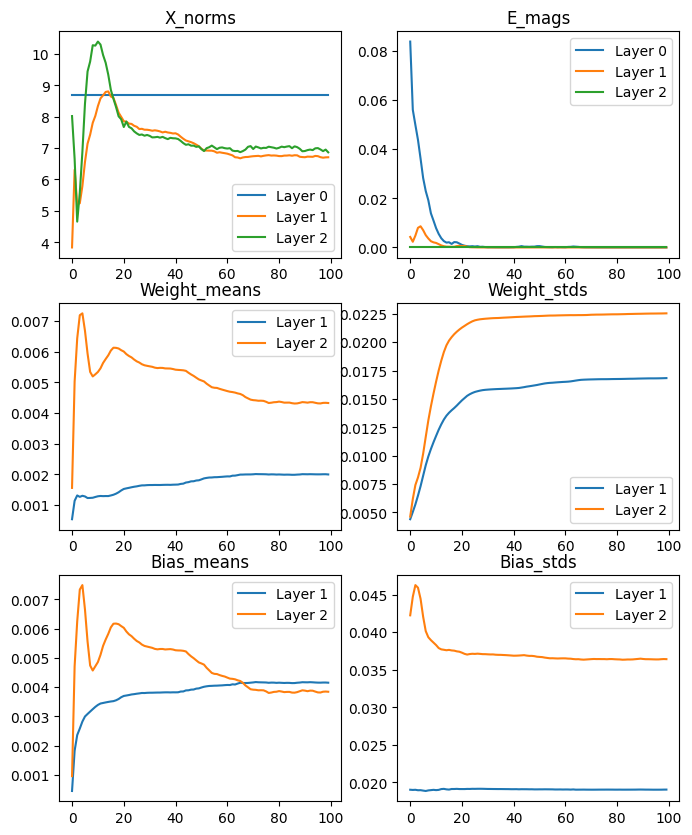

In [28]:
# Train Loop
NUM_EPOCHS = 70
BATCH_SIZE = 1

val_dataset = None

step, stats = train(
    model, 
    train_dataset, 
    val_dataset, 
    NUM_EPOCHS, 
    lr=0.001,
    c_lr=0.0,
    batch_size=BATCH_SIZE,
    reg_coeff=0.02,
    untr_coeff=0.0,
    step=step, 
    stats=stats,
    optim='AdamW',
)
NUM_EPOCHS = 30
step, stats = train(
    model, 
    train_dataset, 
    val_dataset, 
    NUM_EPOCHS, 
    lr=0.0001,
    c_lr=0.01,
    batch_size=BATCH_SIZE,
    reg_coeff=0.02,
    untr_coeff=0.0,
    step=step, 
    stats=stats,
    optim='AdamW',
)

plot_stats(stats, model)

In [8]:

X = train_dataset.transformed_images
X.shape

torch.Size([10, 1, 28, 28])

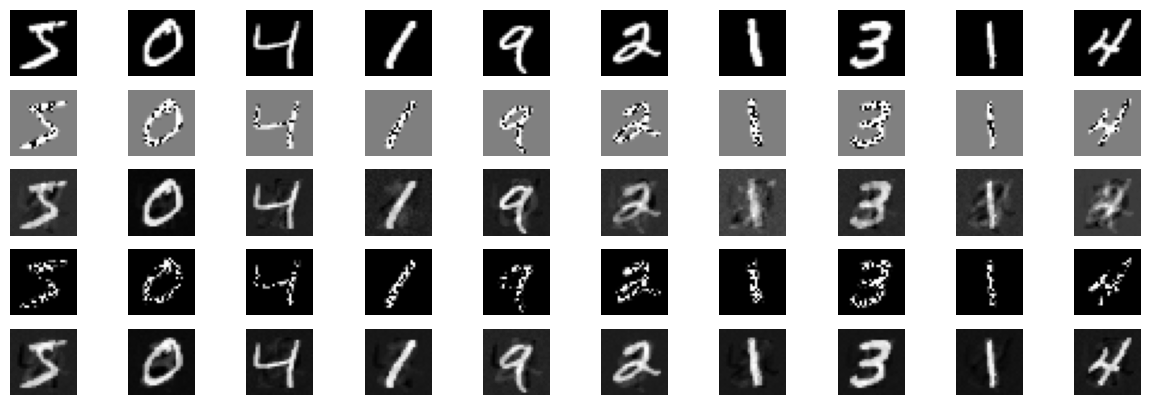

In [29]:
X = train_dataset.transformed_images
X_noisy = X + torch.randn_like(X) * 2.0
X_noisy = F.normalize(X_noisy, dim=1) * X.norm(dim=1, keepdim=True)
X_noisy_recon = model.reconstruct(X_noisy.to(device).flatten(1))[0].view(-1, 1, 28, 28).cpu()
X_partial = X * (torch.rand_like(X) < 0.5).float()
X_partial_recon = model.reconstruct(X_partial.to(device).flatten(1))[0].view(-1, 1, 28, 28).cpu()

# Show all 10 images, raw, noised and reconstructed
fig, axes = plt.subplots(5, 10, figsize=(15, 5))
for i, ax in enumerate(axes[0]):
    ax.imshow(X[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[1]):
    ax.imshow(X_noisy[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[2]):
    ax.imshow(X_noisy_recon[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[3]):
    ax.imshow(X_partial[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[4]):
    ax.imshow(X_partial_recon[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')


In [20]:
plt.plot(stats['train_corr'])

TypeError: 'NoneType' object is not subscriptable

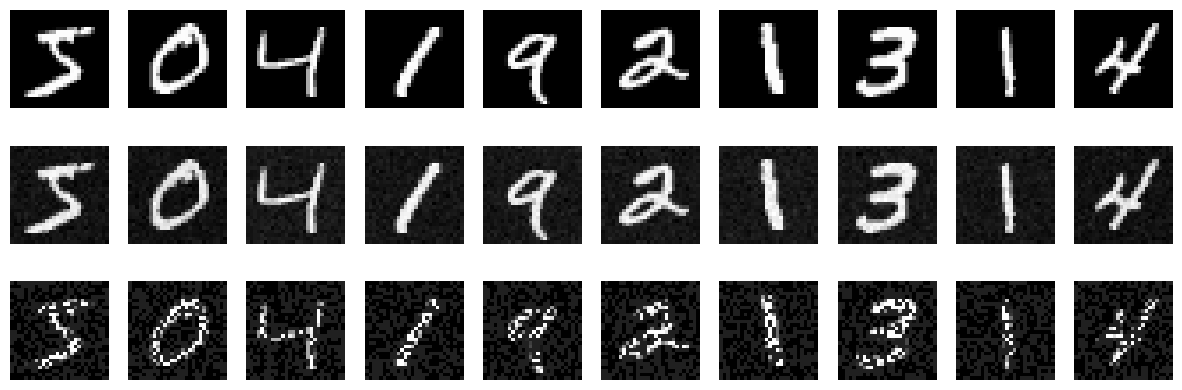

In [7]:
# get 10 images
images = []
noisy_images = []
partial_images = []
labels = []
for i in range(10):
    img, _ = train_dataset[i]
    images.append(img)
    noisy_images.append(img + torch.randn_like(img) * 0.1)
    partial_images.append(img * (torch.rand_like(img) < 0.5))
    labels.append(label)

# show images
fig, axes = plt.subplots(3, 10, figsize=(15, 5))
for i, ax in enumerate(axes[0]):
    ax.imshow(images[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[1]):
    ax.imshow(noisy_images[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[2]):
    ax.imshow(partial_images[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

images = torch.stack(images).flatten(1)
noisy_images = torch.stack(noisy_images).flatten(1)
partial_images = torch.stack(partial_images).flatten(1)

176.5739288330078 147.72362369791668


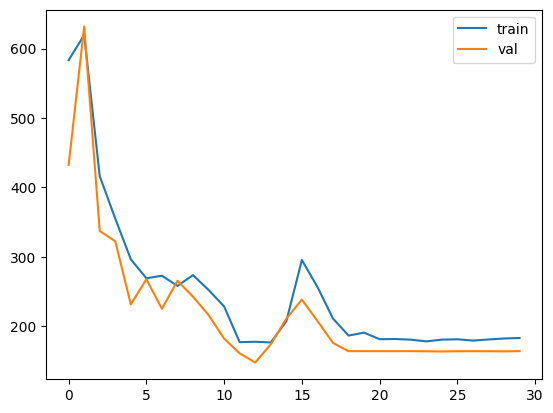

In [10]:
print(min(stats['train_vfe']), min(stats['val_vfe']))
plt.plot(stats['train_vfe'], label='train')
plt.plot(stats['val_vfe'], label='val')
plt.legend()
plt.show()

torch.Size([10, 784])


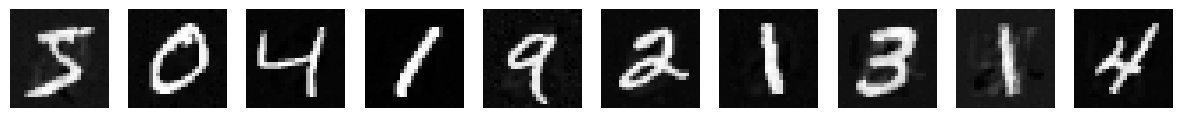

In [17]:
# reconstruct noisy images
out, state = model.reconstruct(noisy_images)
print(out.shape)


# show reconstructed images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(out[i].cpu().reshape(28, 28), cmap='gray')
    ax.axis('off')

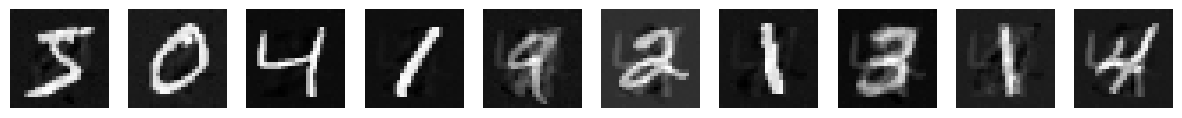

In [18]:
# reconstruct partial images
out, state = model.reconstruct(partial_images)

# show reconstructed images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(out[i].cpu().reshape(28, 28), cmap='gray')
    ax.axis('off')

In [14]:
targets = torch.arange(NUM_CLASSES).to(device)
images = model.generate(targets)

fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img = images[i]
    ax.imshow(img.detach().squeeze().cpu().view(28,28), cmap='gray')
    ax.axis('off')

NotImplementedError: 

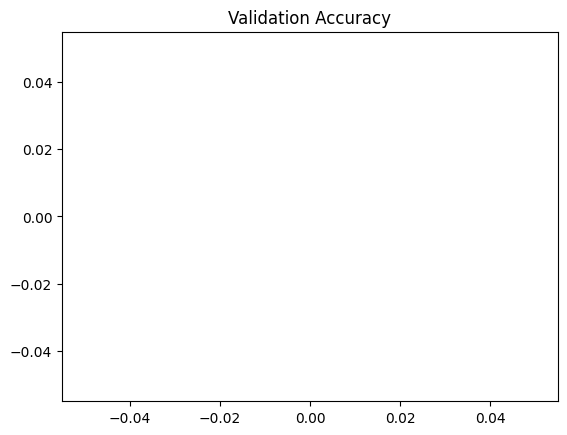

In [23]:
plt.plot(stats['val_acc'])
plt.title("Validation Accuracy")
plt.show()

In [ ]:
max(stats['val_acc'])

0.12591666666666668

In [ ]:
# Current Accuracy and Error Rate
acc = accuracy(model, val_dataset, steps=0)
error = 100 * (1 - acc)
print(f'Current Val Acc: {acc} | error_rate: {error:0.2f} %')

Current Val Acc: 0.136 | error_rate: 86.40 %


In [17]:
# # Shows statistics over multiple models. models = [model1, model2, ...]


# train_vfes = torch.tensor([stats[i]['train_vfe'][-1] for i in range(num_models)])
# val_vfes = torch.tensor([stats[i]['val_vfe'][-1] for i in range(num_models)])
# val_accs = torch.tensor([stats[i]['val_acc'][-1] for i in range(num_models)])

# # Show statistics across models, std is nan if num_models = 1
# print(f"Tra VFE - mean: {train_vfes.mean():.3f} | std: {train_vfes.std():.3f} | min: {train_vfes.min():.3f} | max: {train_vfes.max():.3f}")
# print(f"Val VFE - mean: {val_vfes.mean():.3f} | std: {val_vfes.std():.3f} | min: {val_vfes.min():.3f} | max: {val_vfes.max():.3f}")
# print(f"Val Acc - mean: {val_accs.mean():.3f} | std: {val_accs.std():.3f} | min: {val_accs.min():.3f} | max: {val_accs.max():.3f}")

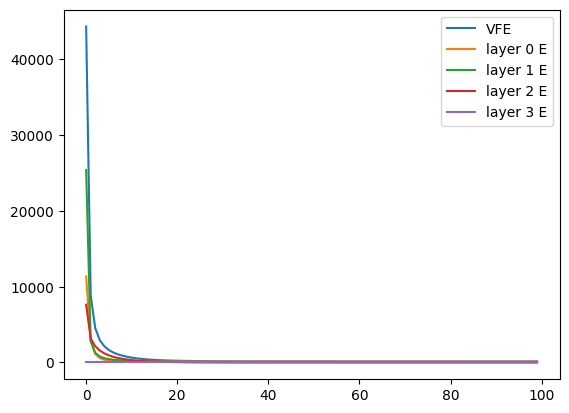

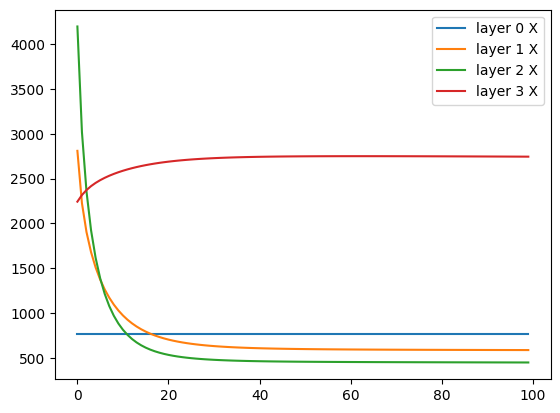

Layer 0 e_min, e_max, x_min, x_max: 767.684, 767.684, 113.817, 11340.142
Layer 1 e_min, e_max, x_min, x_max: 585.531, 2810.468, 31.007, 25379.898
Layer 2 e_min, e_max, x_min, x_max: 446.964, 4199.384, 3.489, 7625.079
Layer 3 e_min, e_max, x_min, x_max: 2242.927, 2750.902, 0.000, 0.000


In [18]:
from pclib.utils.functional import format_y
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
images, y = next(iter(train_loader))
x = images.view(images.shape[0], -1)
y = format_y(y, 10)
vfes, X, E = track_vfe(model, x=x, steps=100, plot_Es=True, plot_Xs=True)
for i in range(len(model.layers)):
    print(f'Layer {i} e_min, e_max, x_min, x_max: {min(E[i]):.3f}, {max(E[i]):.3f}, {min(X[i]):.3f}, {max(X[i]):.3f}')

In [ ]:
assert isinstance(model.layers[0], PrecisionWeighted), "This cell only works for PrecisionWeighted layers"
# show diag of weight_var matrix as 28x28 image for layer 0
model = model
layer = 0
weight_var = model.layers[0].weight_var.detach().cpu().numpy()
# weight_var = model.layers[-1].weight_var.diag().reshape(28,28).detach().cpu().numpy()
plt.imshow(weight_var, cmap='gray')
plt.colorbar()
plt.show()
weight_var.min(), weight_var.max()


AssertionError: This cell only works for PrecisionWeighted layers